
# NSGA-II vs. VEGA — Visualization Notebook

**What is this notebook:**
- Build a reference front (PF\*) from the union of all runs for an instance/preset.
- Overlay algorithm fronts vs PF\* for visual convergence/coverage.
- Per-instance boxplots of GD, IGD, HV, Spread per algorithm.
- A compact runtime summary table (wall time / evaluations).
- Optional 50% attainment (median) curves per algorithm.


In [109]:
from __future__ import annotations
from typing import Dict, Tuple
from pathlib import Path


def find_project_root(start: Path | None = None) -> Path:
    """
    Walk upward from `start` (or CWD) to locate the project root.
    Heuristics:
      - directory containing .git or pyproject.toml or requirements.txt, OR
      - directory that has 'src/' but whose parent does NOT also have 'src/' (topmost src).
    Falls back to current working directory if nothing matches.
    """
    p = (start or Path.cwd()).resolve()
    markers = {".git", "pyproject.toml", "requirements.txt"}
    while True:
        if any((p / m).exists() for m in markers):
            return p
        if (p / "src").exists() and not (p.parent / "src").exists():
            return p
        if p.parent == p:
            # filesystem root reached
            return Path.cwd().resolve()
        p = p.parent

# --- Path adjustments ---
PROJECT_ROOT = find_project_root()                  # .../<project>
SRC_ROOT     = PROJECT_ROOT / "src"                 # alias
FRONTS_DIR   = PROJECT_ROOT / "results" / "fronts"  # where run fronts live (unchanged)

# --- Configuration ---
# Choose the preset folder you want to analyze: "balanced", "fast", or "thorough"
PRESET = "balanced"

# New results location: ROOT/results/<preset_name>/
RESULTS_DIR = PROJECT_ROOT / "results" / "grouped"/PRESET
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Filenames inside each preset folder may be "metrics_auto.csv" and either
# "summary_auto.csv" OR the typo "sumary_auto.csv". Resolve robustly:
def _resolve_metrics_and_summary(dirpath: Path) -> Tuple[str, str]:
    metrics = dirpath / "metrics_auto.csv"
    if not metrics.exists():
        raise FileNotFoundError(f"Missing metrics file: {metrics}")

    summary_candidates = [dirpath / "summary_auto.csv", dirpath / "sumary_auto.csv"]
    summary = next((p for p in summary_candidates if p.exists()), None)
    if summary is None:
        # If not present, create an empty summary with headers so downstream code won’t crash.
        summary = dirpath / "summary_auto.csv"
        if not summary.exists():
            import pandas as pd
            pd.DataFrame(columns=[
                "instance algorithm preset",
                "gd_fixed mean","gd_fixed std",
                "igd_fixed mean","igd_fixed std",
                "hv_fixed mean","hv_fixed std",
                "spread_proxy mean","spread_proxy std",
            ]).to_csv(summary, index=False)
    return str(metrics), str(summary)

METRICS_CSV, SUMMARY_CSV = _resolve_metrics_and_summary(RESULTS_DIR)

# Column names expected in front CSVs:
F1_COL   = "f1_distance"
F2_COL   = "f2_balance_std"
ALGO_COL = "algo"
SEED_COL = "seed"

# Scope (example instance; adjust as needed)
INSTANCE = "B-n45-k6"

# Instance size mapping (unchanged)
WANTED: Dict[str, set] = {
    #"small": {"A-n32-k5", "A-n36-k5"},
    "medium": {"B-n45-k6", "B-n57-k7"},
    # "large":  {"E-n101-k14", "M-n151-k12"},
}
INST2SIZE = {inst: size for size, insts in WANTED.items() for inst in insts}

def infer_size(inst: str) -> str:
    return INST2SIZE.get(inst, "unknown")

# Debug: show where we landed
print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_ROOT    :", SRC_ROOT)
print("FRONTS_DIR  :", FRONTS_DIR)
print("RESULTS_DIR :", RESULTS_DIR)
print("METRICS_CSV :", METRICS_CSV)
print("SUMMARY_CSV :", SUMMARY_CSV)


PROJECT_ROOT: /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2
SRC_ROOT    : /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/src
FRONTS_DIR  : /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/results/fronts
RESULTS_DIR : /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/results/grouped/balanced
METRICS_CSV : /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/results/grouped/balanced/metrics_auto.csv
SUMMARY_CSV : /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/results/grouped/balanced/summary_auto.csv


In [110]:
from pathlib import Path
import pandas as pd
from typing import Optional, Union

import pandas as pd

def read_parquet_resilient(fp):
    """
    Read a Parquet file robustly:
    1) pandas + pyarrow engine
    2) pandas + fastparquet (if installed)
    3) pyarrow directly -> pandas
    """
    try:
        # Try pandas' default (usually pyarrow). This is where your error occurred.
        return pd.read_parquet(fp)
    except Exception as e1:
        # Try fastparquet if present
        try:
            return pd.read_parquet(fp, engine="fastparquet")
        except Exception as e2:
            # Last resort: use pyarrow directly to bypass pandas' hotfix path
            try:
                import pyarrow.parquet as pq
                return pq.read_table(fp).to_pandas()
            except Exception as e3:
                raise RuntimeError(
                    f"Failed to read parquet {fp} via pandas/pyarrow/fastparquet.\n"
                    f"pandas engine error: {e1}\n"
                    f"fastparquet error: {e2}\n"
                    f"pyarrow direct error: {e3}"
                )




def load_fronts(root: Optional[Union[str, Path]],
                instance: str,
                preset: str,
                verbose: bool = False) -> pd.DataFrame:
    """
    Load per-run fronts for a given (instance, preset) from:
      <root>/<instance>/* (preferred Parquet, then NPY, then CSV)

    Accepts file names like:
      nsga2_thorough_seed1000.parquet
      vega_thorough_seed1001.npy
      A-n32-k5__preset=thorough__algo=NSGA2__seed=1000__final_front.csv
    """
    # 0) Resolve root (allow None -> use global FRONTS_DIR if present)
    if root is None:
        try:
            base = Path(FRONTS_DIR)
        except NameError:
            raise ValueError("root is None and FRONTS_DIR is not defined.")
    else:
        base = Path(root)
    folder = base / instance

    # 1) Gather candidates (prefer parquet, then npy, then csv)
    if folder.exists():
        parq = list(folder.glob("*_seed*.parquet")) + list(folder.glob(f"*{preset}*seed*.parquet"))
        npys = list(folder.glob("*_seed*.npy"))     + list(folder.glob(f"*{preset}*seed*.npy"))
        csvs = list(folder.glob("*_seed*.csv"))     + list(folder.glob(f"*{preset}*seed*.csv"))
    else:
        # fallback: search under base (slower, but robust)
        parq = list(base.glob(f"**/{instance}/*_seed*.parquet"))
        npys = list(base.glob(f"**/{instance}/*_seed*.npy"))
        csvs = list(base.glob(f"**/{instance}/*_seed*.csv"))

    search = parq + npys + csvs

    if verbose:
        print(f"[load_fronts] Searching in: {folder if folder.exists() else base}")
        print(f"[load_fronts] Found {len(search)} candidates (parquet={len(parq)}, npy={len(npys)}, csv={len(csvs)})")

    # 2) Filter by preset substring (case-insensitive)
    preset_l = preset.lower()
    files = [fp for fp in search if preset_l in fp.stem.lower()]

    if verbose:
        for fp in files[:8]:
            print("  -", fp.name)
        if not files:
            print("[load_fronts] No files matched preset filter:", preset)

    if not files:
        return pd.DataFrame(columns=["f1_distance", "f2_balance_std", "algo", "seed"])

    def _parse_algo_seed(stem: str):
        # simple: nsga2_thorough_seed1000
        m_algo = re.search(r"(nsga2|vega)", stem, flags=re.I)
        m_seed = re.search(r"seed(\d+)",    stem, flags=re.I)
        algo = m_algo.group(1).upper() if m_algo else None
        seed = int(m_seed.group(1)) if m_seed else None
        # old verbose
        if algo is None:
            m = re.search(r"algo=([A-Za-z0-9_]+)", stem, flags=re.I)
            if m: algo = m.group(1).upper()
        if seed is None:
            m = re.search(r"seed=([0-9]+)", stem, flags=re.I)
            if m: seed = int(m.group(1))
        return (algo or "UNK"), (seed if seed is not None else -1)

    rows = []
    for fp in files:
        algo, seed = _parse_algo_seed(fp.stem)
        # 3) Read by extension
        if fp.suffix.lower() == ".parquet":
            df = read_parquet_resilient(fp)
        elif fp.suffix.lower() == ".npy":
            P = np.load(fp)
            if P.ndim == 1: P = P.reshape(-1, 2)
            df = pd.DataFrame(P, columns=["f1_distance", "f2_balance_std"])
        else:  # csv
            df = pd.read_csv(fp)

        # 4) Normalize columns to canonical names
        lower = {c.lower(): c for c in df.columns}
        f1c = lower.get("f1_distance") or lower.get("f1") or lower.get("distance") or lower.get("obj1")
        f2c = lower.get("f2_balance_std") or lower.get("f2") or lower.get("balance") or lower.get("obj2")
        if f1c is None or f2c is None:
            # permissive fallback: take first two columns if present
            if df.shape[1] >= 2:
                f1c = f1c or df.columns[0]
                f2c = f2c or df.columns[1]
            else:
                if verbose:
                    print(f"[load_fronts] Skip {fp.name}: cannot identify f1/f2 columns")
                continue

        df = df.rename(columns={f1c: "f1_distance", f2c: "f2_balance_std"})[["f1_distance", "f2_balance_std"]].dropna()
        df["algo"] = algo
        df["seed"] = seed
        rows.append(df)

    if not rows:
        return pd.DataFrame(columns=["f1_distance", "f2_balance_std", "algo", "seed"])

    return pd.concat(rows, ignore_index=True)


## Load per-run metrics and summary (optional)

In [111]:

from pathlib import Path
metrics_df = pd.read_csv(METRICS_CSV) if Path(METRICS_CSV).exists() else None
summary_df = pd.read_csv(SUMMARY_CSV) if Path(SUMMARY_CSV).exists() else None

if metrics_df is not None:
    display(metrics_df.head())
    print(f"Loaded metrics from: {METRICS_CSV} — shape: {metrics_df.shape}")
else:
    print("No metrics CSV found at:", METRICS_CSV)

if summary_df is not None:
    display(summary_df.head())
    print(f"Loaded summary from: {SUMMARY_CSV} — shape: {summary_df.shape}")
else:
    print("No summary CSV found at:", SUMMARY_CSV)


,instance,algorithm,preset,seed,gd_fixed,igd_fixed,hv_fixed,spread_proxy
0,A-n32-k5,NSGA2,balanced,1000,236.110173,125.317517,24348.051903,35.361380
1,A-n32-k5,NSGA2,balanced,1001,281.734363,296.892166,49288.435534,11.030531
2,A-n32-k5,NSGA2,balanced,1002,278.214036,74.708491,16863.452486,39.163987
3,A-n32-k5,NSGA2,balanced,1003,252.844390,266.064416,45052.099932,14.472972
4,A-n32-k5,NSGA2,balanced,1004,190.743658,128.549455,26195.713089,28.416781


Loaded metrics from: /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/results/grouped/balanced/metrics_auto.csv — shape: (115, 8)


,instance,algorithm,preset,gd_fixed mean,gd_fixed std,igd_fixed mean,igd_fixed std,hv_fixed mean,hv_fixed std,spread_proxy mean,spread_proxy std
0,A-n32-k5,NSGA2,balanced,2.152239e+02,77.331925,2.131965e+02,111.497927,3.710313e+04,1.495924e+04,21.303820,9.729007
1,A-n32-k5,VEGA,balanced,4.438038e+01,27.715653,1.581641e+02,64.504368,2.682914e+04,8.176093e+03,31.246968,16.042155
2,A-n36-k5,NSGA2,balanced,1.321579e+02,53.864161,1.350351e+02,56.143444,3.039038e+04,8.417974e+03,13.718722,6.894297
3,A-n36-k5,VEGA,balanced,3.637941e+01,24.317440,8.387152e+01,54.508254,2.057397e+04,8.132802e+03,21.029900,20.643829
4,B-n45-k6,NSGA2,balanced,1.414213e+09,82.119119,1.414213e+09,91.654918,1.102499e+18,1.359166e+11,9.903391,6.921002


Loaded summary from: /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/results/grouped/balanced/summary_auto.csv — shape: (6, 11)


## PF* (union) and algorithm front overlays

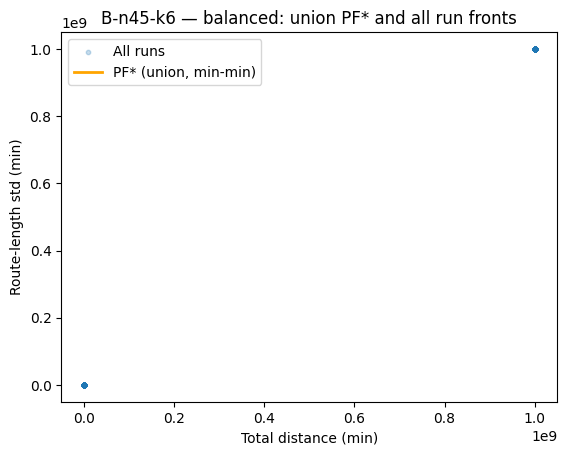

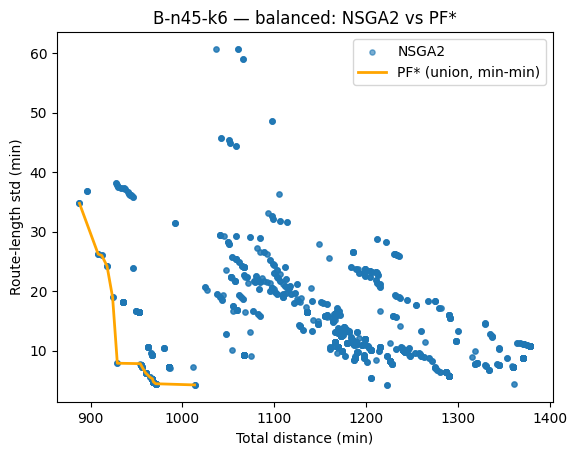

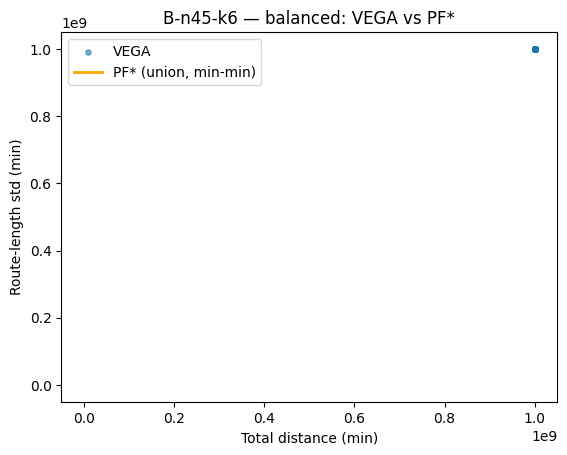

In [112]:
import re
import numpy as np
import matplotlib.pyplot as plt

fronts = load_fronts(FRONTS_DIR, INSTANCE, PRESET)
if fronts.empty:
    raise SystemExit(f"No fronts found in {FRONTS_DIR!r} for instance={INSTANCE!r}, preset={PRESET!r}.\n"
                     "Check your results path and file naming.")

def nondominated_filter(P: np.ndarray) -> np.ndarray:
    """
    Boolean mask of nondominated points for MINIMIZATION.
    Removes points q where p <= q in all dims and p < q in at least one.
    """
    if P.size == 0:
        return np.zeros(0, dtype=bool)
    n = P.shape[0]
    keep = np.ones(n, dtype=bool)
    for i, p in enumerate(P):
        if not keep[i]:
            continue
        # points dominated BY p (i.e., p is as good or better in all dims, and strictly better in one)
        dominated_by_p = np.all(P >= p, axis=1) & np.any(P > p, axis=1)
        dominated_by_p[i] = False  # don't compare with itself
        keep[dominated_by_p] = False
    return keep


xy = fronts[["f1_distance","f2_balance_std"]].to_numpy()
keep = nondominated_filter(xy)
pf_star = fronts.loc[keep, ["f1_distance","f2_balance_std"]].sort_values(["f1_distance","f2_balance_std"]).reset_index(drop=True)

# --- union view ---
plt.figure()
plt.scatter(fronts["f1_distance"], fronts["f2_balance_std"], s=10, alpha=0.25, label="All runs")
plt.plot(
    pf_star["f1_distance"], pf_star["f2_balance_std"],
    linewidth=2, color="orange", label="PF* (union, min-min)", zorder=5
)
plt.title(f"{INSTANCE} — {PRESET}: union PF* and all run fronts")
plt.xlabel("Total distance (min)"); plt.ylabel("Route-length std (min)")
plt.legend()
plt.show()

# --- per-algorithm views ---
for algo in sorted(fronts["algo"].unique()):
    df = fronts[fronts["algo"] == algo]
    plt.figure()
    plt.scatter(df["f1_distance"], df["f2_balance_std"], s=14, alpha=0.6, label=algo)
    plt.plot(
        pf_star["f1_distance"], pf_star["f2_balance_std"],
        linewidth=2, color="orange", label="PF* (union, min-min)", zorder=5
    )
    plt.title(f"{INSTANCE} — {PRESET}: {algo} vs PF*")
    plt.xlabel("Total distance (min)"); plt.ylabel("Route-length std (min)")
    plt.legend()
    plt.show()


## Metric boxplots per algorithm (GD, IGD, HV, Spread)

size    preset algorithm      gd_fixed                           \
                                        mean        std           min   
0   medium  balanced     NSGA2  1.414213e+09  82.119120  1.414213e+09   
1   medium  balanced      VEGA  0.000000e+00   0.000000  0.000000e+00   
2  unknown  balanced     NSGA2  1.736909e+02  78.077804  3.242094e+01   
3  unknown  balanced      VEGA  4.037990e+01  26.052494  6.618015e-01   

                                        igd_fixed  ...      hv_fixed  \
            max        median count          mean  ...           min   
0  1.414213e+09  1.414213e+09    20  1.414213e+09  ...  1.102499e+18   
1  0.000000e+00  0.000000e+00    15  0.000000e+00  ...  2.500000e+15   
2  2.817344e+02  1.749456e+02    40  1.741158e+02  ...  9.345882e+03   
3  1.146889e+02  3.687754e+01    40  1.210178e+02  ...  6.093151e+03   

                                    spread_proxy                       \
            max        median count         mean        std       min   
0  1.102499e+18  1.102499e+18    20     9.903391   6.921002  0.424103   
1  2.500000e+15  2.500000e+15    15     0.000000   0.000000  0.000000   
2  6.343762e+04  3.217343e+04    40    17.511271   9.166341  4.276676   
3  4.152177e+04  2.239487e+04    40    26.138434  18.967404  0.000000   

                               
         max     median count  
0  31.993877   8.730839    20  
1   0.000000   0.000000    15  
2  39.163987  16.183228    40  
3  85.455428  24.291586    40  

[4 rows x 27 columns]

Skip GD (↓): no rows for size=small, preset=balanced
Skip IGD (↓): no rows for size=small, preset=balanced
Skip Hypervolume (↑): no rows for size=small, preset=balanced
Skip Spread proxy (↓): no rows for size=small, preset=balanced


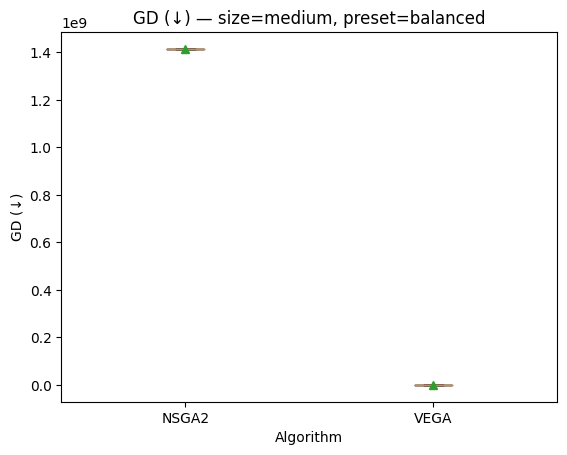

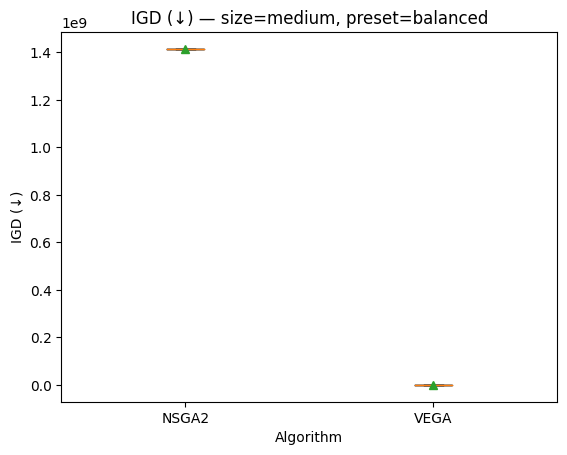

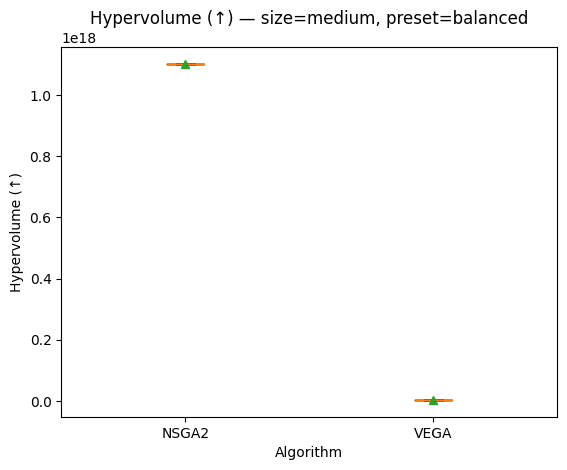

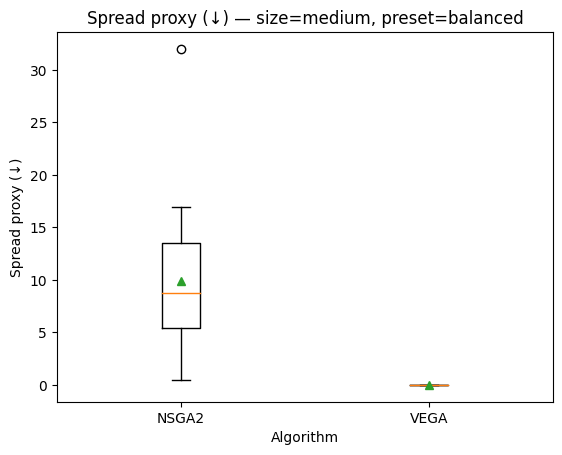

Skip GD (↓): no rows for size=large, preset=balanced
Skip IGD (↓): no rows for size=large, preset=balanced
Skip Hypervolume (↑): no rows for size=large, preset=balanced
Skip Spread proxy (↓): no rows for size=large, preset=balanced


In [113]:
import matplotlib.pyplot as plt


def find_col(df: pd.DataFrame, candidates) -> str | None:
    """
    Return the first column name in df whose lowercase form matches
    one of the candidate strings. Returns None if not found.
    """
    for c in candidates:
        for col in df.columns:
            if col.lower() == c:
                return col
    return None


if metrics_df is None:
    print("Skip: no metrics CSV loaded.")
else:
    inst_col   = "instance"
    algo_col   = "algorithm"
    gd_col     = "gd_fixed"
    igd_col    = "igd_fixed"
    hv_col     = "hv_fixed"
    spread_col = "spread_proxy"
    metrics_df["size"] = metrics_df[inst_col].map(infer_size)
    preset_col = "preset"

    metric_cols = ["gd_fixed", "igd_fixed", "hv_fixed", "spread_proxy"]
    agg = (metrics_df
       .groupby(["size", preset_col, algo_col])[metric_cols]
       .agg(["mean", "std", "min", "max", "median", "count"])
       .reset_index())

    display(agg)

def metric_boxplot(df, instance, metric_col, title):
        sub = df[df[inst_col] == instance]
        if sub.empty or metric_col not in sub.columns:
            print(f"No data for {instance} or missing column {metric_col}.")
            return
        algos = list(pd.unique(sub[algo_col]))
        if len(algos) < 2:
            print(f"Only one algorithm present for {instance}, skip boxplot.")
            return
        data = [sub[sub[algo_col]==a][metric_col].dropna() for a in algos]
        plt.figure()
        plt.boxplot(data, labels=algos, showmeans=True)
        plt.title(f"{title} — {instance}")
        plt.ylabel(title); plt.xlabel("Algorithm")
        plt.show()

        for inst in [INSTANCE]:
            metric_boxplot(metrics_df, inst, gd_col,   "GD (↓)")
            metric_boxplot(metrics_df, inst, igd_col,  "IGD (↓)")
            metric_boxplot(metrics_df, inst, hv_col,   "Hypervolume (↑)")
            metric_boxplot(metrics_df, inst, spread_col, "Spread proxy (↓)")


def metric_boxplot_by_size(df, size, preset, metric_col, title):
        sub = df[(df["size"]==size) & (df[preset_col]==preset)]
        if sub.empty:
            print(f"Skip {title}: no rows for size={size}, preset={preset}")
            return
        algos = list(sub[algo_col].unique())
        if len(algos) < 2:
            print(f"Only one algo for size={size}, preset={preset}, skip.")
            return
        data = [sub[sub[algo_col]==a][metric_col].dropna() for a in algos]
        plt.figure()
        plt.boxplot(data, labels=algos, showmeans=True)
        plt.title(f"{title} — size={size}, preset={preset}")
        plt.ylabel(title)
        plt.xlabel("Algorithm")
        plt.show()

sizes   = ["small","medium","large"]               # or metrics_df["size"].unique()
presets = sorted(metrics_df[preset_col].unique())  # e.g. fast/balanced/thorough

for s in sizes:
    for p in presets:
        metric_boxplot_by_size(metrics_df, s, p, "gd_fixed",        "GD (↓)")
        metric_boxplot_by_size(metrics_df, s, p, "igd_fixed",       "IGD (↓)")
        metric_boxplot_by_size(metrics_df, s, p, "hv_fixed",        "Hypervolume (↑)")
        metric_boxplot_by_size(metrics_df, s, p, "spread_proxy",    "Spread proxy (↓)")


In [121]:
from pathlib import Path
import pandas as pd

# --- locations ---
PROJECT_ROOT = find_project_root()
PRESET = PRESET if "PRESET" in globals() else "thorough"

METRICS_PATH = PROJECT_ROOT / "results" / "grouped" / PRESET / "metrics_auto.csv"

# Optional: let a variable override the runtime path; otherwise try common locations + your absolute path
RUNTIME_PATH_OVERRIDE = None  # e.g., Path("/custom/path/runtime_summary.csv")

def resolve_runtime_summary() -> Path | None:
    if RUNTIME_PATH_OVERRIDE:
        return Path(RUNTIME_PATH_OVERRIDE)
    candidates = [
        PROJECT_ROOT / "results" / "runtime_summary.csv"
    ]
    for p in candidates:
        if p.exists():
            return p
    # last resort: search only for the exact filename under results/
    hits = list((PROJECT_ROOT / "results").rglob("runtime_summary.csv"))
    return hits[0] if hits else None

# --- load inputs ---
if not METRICS_PATH.exists():
    raise FileNotFoundError(f"metrics_auto.csv not found: {METRICS_PATH}")
metrics_df = pd.read_csv(METRICS_PATH)

runtime_path = resolve_runtime_summary()
if runtime_path is None:
    raise FileNotFoundError("runtime_summary.csv not found under results/.")
runtime_df = pd.read_csv(runtime_path)

# --- helpers ---
def _pick(df: pd.DataFrame, names):
    for n in names:
        for c in df.columns:
            if c.lower() == n:
                return c
    return None

# --- key columns on metrics side ---
m_inst   = _pick(metrics_df, ["instance","inst","problem"]) or "instance"
m_algo   = _pick(metrics_df, ["algorithm","algo"])          or "algorithm"
m_preset = _pick(metrics_df, ["preset"])                    or "preset"

# --- key columns on runtime side (grouped by instance/algorithm/preset) ---
r_inst   = _pick(runtime_df, ["instance","inst","problem"]) or "instance"
r_algo   = _pick(runtime_df, ["algorithm","algo"])          or "algorithm"
r_preset = _pick(runtime_df, ["preset"])                    or "preset"

# pick runtime/evaluations columns created by exp_runner.py aggregation
rt_mean = _pick(runtime_df, ["wall_clock_s mean","mean_wall_clock_s","wall_clock_mean","runtime_mean"])
rt_std  = _pick(runtime_df, ["wall_clock_s std","std_wall_clock_s","wall_clock_std","runtime_std"])
ev_mean = _pick(runtime_df, ["evaluations mean","evals mean","evaluations_mean"])
ev_std  = _pick(runtime_df, ["evaluations std","evals std","evaluations_std"])

# slim runtime table
keep_cols = [r_inst, r_algo, r_preset] + [c for c in [rt_mean, rt_std, ev_mean, ev_std] if c is not None]
runtime_slim = runtime_df[keep_cols].copy()

# normalize strings to avoid merge misses
for (cm, cr) in [(m_inst, r_inst), (m_algo, r_algo), (m_preset, r_preset)]:
    metrics_df[cm]    = metrics_df[cm].astype(str).str.strip()
    runtime_slim[cr]  = runtime_slim[cr].astype(str).str.strip()

# rename to stable names
rename_map = {}
if rt_mean: rename_map[rt_mean] = "rt_mean_s"
if rt_std:  rename_map[rt_std]  = "rt_std_s"
if ev_mean: rename_map[ev_mean] = "evaluations_mean"
if ev_std:  rename_map[ev_std]  = "evaluations_std"
runtime_slim = runtime_slim.rename(columns=rename_map)

# --- merge: add aggregated runtime/evaluations to each metrics row (by instance/algorithm/preset) ---
merged = metrics_df.merge(
    runtime_slim,
    left_on=[m_inst, m_algo, m_preset],
    right_on=[r_inst, r_algo, r_preset],
    how="left",
    suffixes=("", "_rt")
)

# optional: drop duplicate key cols from runtime side if present
dup_keys = [c for c in [r_inst, r_algo, r_preset] if c in merged.columns and c not in [m_inst, m_algo, m_preset]]
merged = merged.drop(columns=dup_keys, errors="ignore")

# quick sanity print
print(f"Loaded metrics: {METRICS_PATH}")
print(f"Loaded runtime: {runtime_path}")
print("Merged shape:", merged.shape)
display(merged.head())

# example aggregate with runtime present
if "rt_mean_s" in merged.columns:
    agg = (merged.groupby([m_preset, m_algo])[["gd_fixed","igd_fixed","hv_fixed","spread_proxy","rt_mean_s","rt_std_s"]]
           .agg(["mean","std","count"])
           .reset_index())
    agg.columns = [' '.join(c).strip() if isinstance(c, tuple) else c for c in agg.columns]
    display(agg)


Loaded metrics: /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/results/grouped/balanced/metrics_auto.csv
Loaded runtime: /Users/kristina/Dropbox/Mac/Desktop/ACIT4610-project2/ACIT4610-project2/results/runtime_summary.csv
Merged shape: (115, 12)


,instance,algorithm,preset,seed,gd_fixed,igd_fixed,hv_fixed,spread_proxy,rt_mean_s,rt_std_s,evaluations_mean,evaluations_std
0,A-n32-k5,NSGA2,balanced,1000,236.110173,125.317517,24348.051903,35.361380,9.407037,0.041912,16100.0,25.455844
1,A-n32-k5,NSGA2,balanced,1001,281.734363,296.892166,49288.435534,11.030531,9.407037,0.041912,16100.0,25.455844
2,A-n32-k5,NSGA2,balanced,1002,278.214036,74.708491,16863.452486,39.163987,9.407037,0.041912,16100.0,25.455844
3,A-n32-k5,NSGA2,balanced,1003,252.844390,266.064416,45052.099932,14.472972,9.407037,0.041912,16100.0,25.455844
4,A-n32-k5,NSGA2,balanced,1004,190.743658,128.549455,26195.713089,28.416781,9.407037,0.041912,16100.0,25.455844


,preset,algorithm,gd_fixed mean,gd_fixed std,gd_fixed count,igd_fixed mean,igd_fixed std,igd_fixed count,hv_fixed mean,hv_fixed std,hv_fixed count,spread_proxy mean,spread_proxy std,spread_proxy count,rt_mean_s mean,rt_mean_s std,rt_mean_s count,rt_std_s mean,rt_std_s std,rt_std_s count
0,balanced,NSGA2,4.714044e+08,6.722922e+08,60,4.714044e+08,6.722922e+08,60,3.674996e+17,5.241088e+17,60,14.975311,9.167635,60,10.889193,1.199691,60,0.133595,0.075606,60
1,balanced,VEGA,2.936720e+01,2.862860e+01,55,8.801296e+01,8.056149e+01,55,6.818182e+14,1.123666e+15,55,19.009770,19.946232,55,10.961864,1.369240,55,0.056458,0.022392,55


## Optional: 50% attainment (median) curves

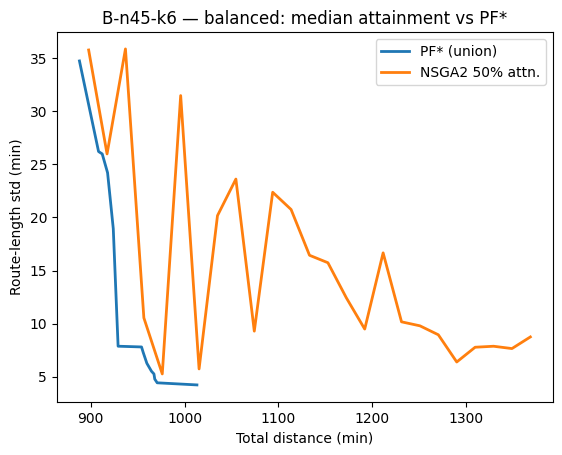

In [122]:

def median_attainment(fronts_df: pd.DataFrame, algo: str, bins: int = 30) -> pd.DataFrame:
    df = fronts_df[fronts_df["algo"]==algo]
    if df.empty:
        return pd.DataFrame(columns=["f1_distance","f2_med"])
    f1 = df["f1_distance"].to_numpy()
    f2 = df["f2_balance_std"].to_numpy()
    edges = np.linspace(f1.min(), f1.max(), bins+1)
    mids  = 0.5*(edges[:-1]+edges[1:])
    med = []
    for lo, hi in zip(edges[:-1], edges[1:]):
        mask = (f1>=lo) & (f1<hi)
        med.append(np.nanmedian(f2[mask]) if np.any(mask) else np.nan)
    att = pd.DataFrame({"f1_distance": mids, "f2_med": med}).dropna()
    return att

att_curves = {}
for algo in sorted(fronts["algo"].unique()):
    att_curves[algo] = median_attainment(fronts, algo, bins=25)

plt.figure()
plt.plot(pf_star["f1_distance"], pf_star["f2_balance_std"], linewidth=2, label="PF* (union)")
for algo, att in att_curves.items():
    if not att.empty:
        plt.plot(att["f1_distance"], att["f2_med"], linewidth=2, label=f"{algo} 50% attn.")
plt.title(f"{INSTANCE} — {PRESET}: median attainment vs PF*")
plt.xlabel("Total distance (min)"); plt.ylabel("Route-length std (min)")
plt.legend()
plt.show()
